In [1]:
from src.lineage.lineage_enrichment import create_enrich, plot_volcano, wrap_plot_volcano, run_enrichment_stats
import glob
import os 
from os.path import join, exists
import pandas as pd
import numpy as np
from icecream import ic

In [2]:
clones_indir = "/data2/isshamie/mito_lineage/data/barplots/"
outdir = "./Results"

In [3]:
if not exists(outdir):
    os.mkdir(outdir)

In [4]:
glob.glob(clones_indir+"*")

['/data2/isshamie/mito_lineage/data/barplots/barplots.ipynb',
 '/data2/isshamie/mito_lineage/data/barplots/chip_clones',
 '/data2/isshamie/mito_lineage/data/barplots/cd34_clones',
 '/data2/isshamie/mito_lineage/data/barplots/output_properLabel',
 '/data2/isshamie/mito_lineage/data/barplots/chip_b_clones',
 '/data2/isshamie/mito_lineage/data/barplots/output']

In [5]:
nclones=20

labels_map = {"chip":{"Flt3l":"Input", "Input": "Control", "Control":"Flt3l"}}

in_dirs = {"chip":join(clones_indir, "chip_b_clones/lineage20/cells_meta.tsv"),
          "cd34norm": join(clones_indir,
                               "cd34_clones/lineage20/cells_meta.tsv")}

in_names = {"chip": ["Control", "Flt3l", "Input"],
            "cd34norm": ["Control", "Flt3l"]
           }

in_samples = in_names 
# samples = names {"cd34norm": ["P2", "J2"],
#         "chip": ["Control", "Flt3l", "Input"]}


In [6]:
def load_cells_meta(in_f, label_map=None, correct_condition=True):
    cells_meta = pd.read_csv(in_f,
                             sep='\t')
    cells_meta["lineage"] = cells_meta["lineage"].astype('Int64')
    cells_meta["donor"] = cells_meta["donor"].astype('Int64')
    
    if label_map is not None and correct_condition:
        print("changing labels")
        print(label_map)
        cells_meta["condition"] = cells_meta["condition"].map(label_map)
    return cells_meta


def norm_clones(clust_counts, names):
    clust_counts_norm = (clust_counts+1).copy().astype(np.double)
    clust_counts_norm  = clust_counts_norm.div(clust_counts_norm.sum(axis=1), axis='rows')
    # print('clust_counts_norm')
    # print(clust_counts_norm)
    fold_df_norm = pd.DataFrame(
                (clust_counts_norm.loc[f"# {names[1]} Cells in Cluster"]) / (
                    clust_counts_norm.loc[f"# {names[0]} Cells in Cluster"])).transpose()
    fold_df_norm = fold_df_norm.rename({0: f"{names[1]} fold enrichment norm"}, axis=0)
    return fold_df_norm


def run_enrich_single(curr_donor, names,d, pseudocount=1):
    all_enrich_norm = {}
    clust_counts = curr_donor.groupby(["condition", "lineage"]).size().reset_index().pivot(index='condition',columns='lineage', values=0).fillna(0)
    clust_counts = clust_counts + pseudocount
    if len(clust_counts) == 0:
        print("No lineages detected in donor. Continuing")
        return
    clust_counts = clust_counts.rename({x:y for (x,y) in zip(samples, names)}, axis=0)

    #clust_counts.columns = clust_counts.columns.astype('Int64')
    clust_counts.index = [f"# {x} Cells in Cluster" for x in clust_counts.index]
    ###############################################################
    clust_counts = clust_counts.astype('Int64')

    # Get enrichment
    if "Input" in names:
        enrich_df = run_enrichment_stats(clust_counts.drop("# Input Cells in Cluster", axis=0), flt_var=names[1])
    else:
        enrich_df = run_enrichment_stats(clust_counts, flt_var=names[1])

#     fold_df = pd.DataFrame(
#             (clust_counts.loc[f"# {names[1]} Cells in Cluster"] + 1) / (
#                     clust_counts.loc[f"# {names[0]} Cells in Cluster"] + 1)).transpose()
#     fold_df = fold_df.rename({0: f"{names[1]} fold enrichment"}, axis=0)    
    
    ### Convert cluster numbers into probablilites.
    clust_counts_norm = (clust_counts+1).copy().astype(np.double)
    clust_counts_norm  = clust_counts_norm.div(clust_counts_norm.sum(axis=1), axis='rows')
    fold_df_norm = pd.DataFrame(
                (clust_counts_norm.loc[f"# {names[1]} Cells in Cluster"]) / (
                    clust_counts_norm.loc[f"# {names[0]} Cells in Cluster"])).transpose()
    fold_df_norm = fold_df_norm.rename({0: f"{names[1]} fold enrichment norm"}, axis=0)
    enrich_stats = create_enrich(clust_counts, fold_df_norm,  enrich_df)
    return enrich_stats


def run_enrich(clones_indir, names, label_map=None):
    all_enrich_norm = {}
    cells_meta = load_cells_meta(clones_indir, label_map=label_map)
    for d, curr_donor in cells_meta.groupby("donor"):
        ic("donor", d)
        all_enrich_norm[(d, nclones)] = run_enrich_single(curr_donor, names, d)
        
    all_enrich_df = pd.concat(all_enrich_norm).reset_index().rename({"level_0": "Donor", "level_1": "clones"}, axis=1)
    all_enrich_df["Donor"] = all_enrich_df["Donor"].astype(object)
    return all_enrich_df


def plot_enrich(all_enrich_df, outdir, name):
    for nclones_ind, val in all_enrich_df.groupby("clones"):
        # Main figure is Fisher norm results
        plot_volcano(val, hue="Donor", x=f"{names[1]} fold enrichment norm",
                     size=f"# {names[1]} Cells in Cluster",
                     f_save=join(outdir, f"{name}volcano_Fisher_foldNorm.png"), v=1, to_close=False, to_log=False)

        plot_volcano(val, hue="Donor", x=f"{names[1]} fold enrichment norm",
                     size=f"# {names[1]} Cells in Cluster",
                     f_save=join(outdir, f"{name}volcano_Fisher_foldLogNorm.png"), v=1, to_close=False, to_log=True) 

ic| 'donor', d: 0
ic| 'df'
ic| df.head(): lineage                     0   1   2   3   4   5   6   7   8   9   10  11  \
               # Control Cells in Cluster   2   2   1  11   1   4   2   2   3   1   2   2   
               # Flt3l Cells in Cluster    16   2  25  30   1  11   3   2   1   1   1   5   
               
               lineage                     12  13  14  15  16  17  18  19  
               # Control Cells in Cluster   6   2   1   1   1   1   1   1  
               # Flt3l Cells in Cluster     1   2   1   7   3   1   2   3  


changing labels
{'Flt3l': 'Input', 'Input': 'Control', 'Control': 'Flt3l'}


ic| 'donor', d: 1
ic| 'df'
ic| df.head(): lineage                     0   1   2   3   4   5   6   7   8   9   10  11  \
               # Control Cells in Cluster   2  10   2   1   1   7   2   4   1   2   4   5   
               # Flt3l Cells in Cluster     1   4   1   2   2   8   1  21   2   4   7   2   
               
               lineage                     12  13  14  15  16  17  18  19  
               # Control Cells in Cluster   3   2   1   3   3   1   2   2  
               # Flt3l Cells in Cluster     2   1   1   4   8   1   4   3  
ic| 'donor', d: 2
ic| 'df'
ic| df.head(): lineage                     0   1   2   3   4   5   6   7   8   9   10  11  \
               # Control Cells in Cluster   4   1   2   1   1   3   2   1   1   1   1  10   
               # Flt3l Cells in Cluster     1   1   8   1   2   1   4   1   5   1   1  18   
               
               lineage                     12  13  14  15  16  17  18  19  
               # Control Cells in Cluster   3   2   

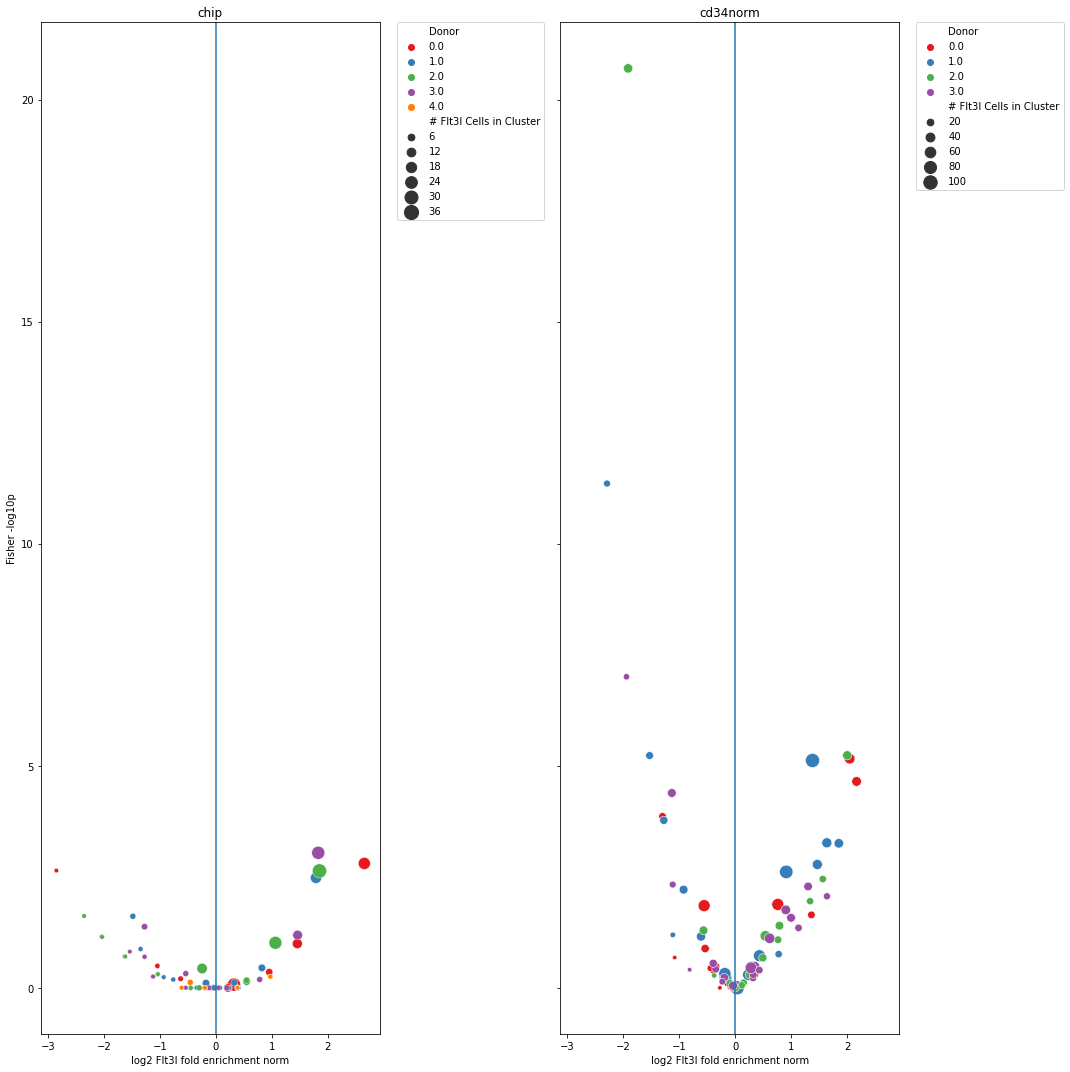

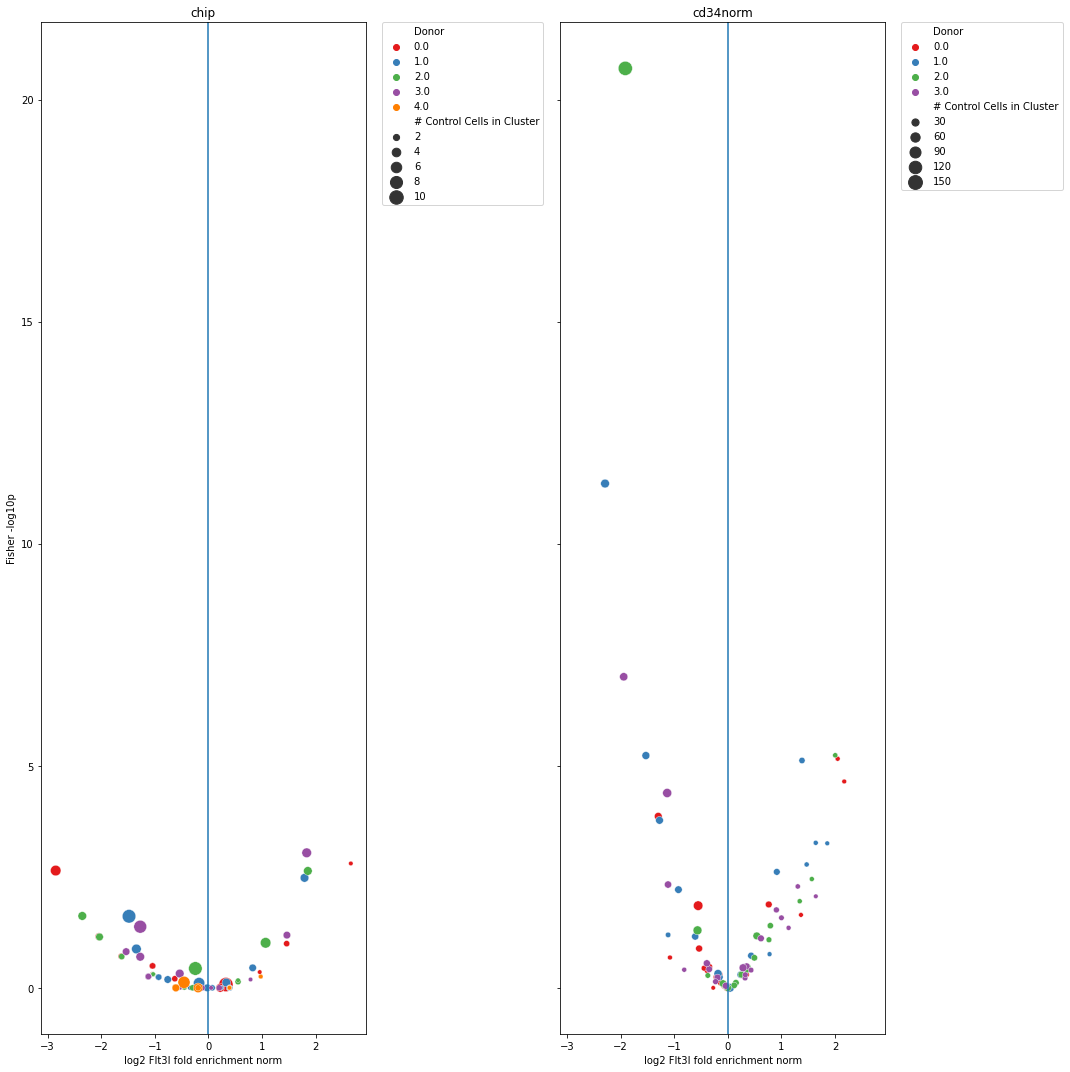

In [11]:
%matplotlib inline
enrich_stats_all = {}

for i in in_dirs:
    in_dir = in_dirs[i]
    names = in_names[i]
    samples = in_samples[i]
    if i in labels_map:
        label_map = labels_map[i]
    else:
        label_map=None
        
    enrich_df = run_enrich(in_dir, names, label_map=label_map)
    
    enrich_stats_all[i] = enrich_df
        
wrap_plot_volcano(enrich_stats_all, x="Flt3l fold enrichment norm",
                  f_save=join(outdir, f"volcano_Fisher_foldLogNorm.png"),to_log=True,
                  size="# Flt3l Cells in Cluster",hue="Donor")

wrap_plot_volcano(enrich_stats_all, x="Flt3l fold enrichment norm",
                  f_save=join(outdir, f"volcano_Fisher_foldLogNorm_controlSize.png"),to_log=True,
                  size="# Control Cells in Cluster",hue="Donor")

In [8]:
# all_enrich_df = run_enrich(in_dirs["cd34norm"], in_names["cd34norm"])

# # le(clones_indir, outdir, nclones, samples,
# #                        plot_ind, name="", names=None)

# %matplotlib inline
# plot_enrich(all_enrich_df.astype(float), outdir, in_names["cd34norm"])

In [9]:

# clust_counts = curr_donor.groupby(["condition", "lineage"]).size().reset_index().pivot(index='condition',columns='lineage', values=0).fillna(0)
# clust_counts = clust_counts.rename({x:y for (x,y) in zip(samples, names)}, axis=0)

# #clust_counts.columns = clust_counts.columns.astype('Int64')
# clust_counts.index = [f"# {x} Cells in Cluster" for x in clust_counts.index]
# ###############################################################
# clust_counts = clust_counts.astype('Int64')
# print('clust_counts')
# print(clust_counts)

# # Get enrichment
# if "Input" in names:
#     enrich_df = run_enrichment_stats(clust_counts.drop("# Input Cells in Cluster", axis=0), flt_var=names[1])
# else:
#     enrich_df = run_enrichment_stats(clust_counts, flt_var=names[1])

# fold_df = pd.DataFrame(
#         (clust_counts.loc[f"# {names[1]} Cells in Cluster"] + 1) / (
#                 clust_counts.loc[f"# {names[0]} Cells in Cluster"] + 1)).transpose()
# fold_df = fold_df.rename({0: f"{names[1]} fold enrichment"}, axis=0)    

# ### Convert cluster numbers into probablilites.
# clust_counts_norm = (clust_counts+1).copy().astype(np.double)
# clust_counts_norm  = clust_counts_norm.div(clust_counts_norm.sum(axis=1), axis='rows')
# fold_df_norm = pd.DataFrame(
#             (clust_counts_norm.loc[f"# {names[1]} Cells in Cluster"]) / (
#                 clust_counts_norm.loc[f"# {names[0]} Cells in Cluster"])).transpose()
# fold_df_norm = fold_df_norm.rename({0: f"{names[1]} fold enrichment norm"}, axis=0)


In [10]:
pwd

'/data2/mito_lineage/notebooks/enrichment_v2_sep292021'